In [33]:
import math
from pathlib import Path
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from challenge.src.common import load_data, prepare_train_data, generate_submission
from challenge.src.eval import evaluate_retrieval, visualize_retrieval
# ==== Config ====
MODEL_PATH = "models/maxmatch_adapter_k4_sinkhorn.pth"
EPOCHS = 20
BATCH_SIZE = 256
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MaxMatch / Set-based
K_SLOTS = 6
SLOT_DROPOUT_P = 0.12

SINKHORN_ITERS = 12
SINKHORN_TAU   = 0.20
DETACH_ASSIGNMENT = True

SCALE_S = 0.5
DELTA_1 = 0.20
DELTA_2 = 0.60
DELTA_3 = 0.60

LAMBDA_ISDL = 0.10
LAMBDA_GDL  = 0.10
LAMBDA_MMD  = 0.01
LAMBDA_DIV  = 0.01

EPOCHS   = 30
LR       = 1e-3



# ============================================================
# 1) Head set-based: t(1024) -> S_T (K x 1536)
# ============================================================
class SetPredictionHead(nn.Module):
    """
    Converte un embedding testuale globale in K slot nello spazio visivo (1536).
    - K query vettori learnable (inizializzati nel target space).
    - Proiezione testo -> spazio visivo + gating per diversificare contributi.
    - Piccolo dropout per evitare collasso precoce.
    """
    def __init__(self, d_text=1024, d_vis=1536, K=4, hidden=2048, slot_dropout_p=0.1):
        super().__init__()
        self.K = K
        self.d_vis = d_vis

        self.text_to_vis = nn.Sequential(
            nn.Linear(d_text, hidden),
            nn.GELU(),
            nn.Linear(hidden, d_vis),
        )

        self.slot_queries = nn.Parameter(torch.randn(K, d_vis) * 0.02)
        self.gate_per_slot = nn.Linear(d_text, K)
        self.delta_per_slot = nn.Linear(d_text, K * d_vis)

        self.ln_slots = nn.LayerNorm(d_vis)
        self.ln_text  = nn.LayerNorm(d_vis)
        self.dropout = nn.Dropout(p=slot_dropout_p)

    def forward(self, t: torch.Tensor):
        B = t.size(0)
        t_vis = self.text_to_vis(t)                 # (B, d_vis)
        t_vis = self.ln_text(t_vis)

        gate  = torch.sigmoid(self.gate_per_slot(t))      # (B, K)
        delta = self.delta_per_slot(t).view(B, self.K, self.d_vis)

        Q = self.slot_queries.unsqueeze(0).expand(B, -1, -1)  # (B, K, d_vis)
        t_vis_exp = t_vis.unsqueeze(1).expand(-1, self.K, -1)
        gate_exp  = gate.unsqueeze(-1)

        # --- residui (pre-fusione globale) ---
        R = Q + gate_exp * t_vis_exp + delta               # (B, K, d_vis)
        R = self.ln_slots(R)
        R = self.dropout(R)
        E_T = F.normalize(R, dim=-1)                       # residui normalizzati (per ISDL)

        # --- fusione globale per scoring ---
        S_T = E_T + F.normalize(t_vis, dim=-1).unsqueeze(1)
        S_T = F.normalize(S_T, dim=-1)
        return S_T, E_T, F.normalize(t_vis, dim=-1)
# ============================================================
# 2) Sinkhorn matching (soft, entropic-regularized doubly-stochastic)
#    sim -> P ~ doubly-stochastic, poi S_H = <P, sim>/K
# ============================================================
def sinkhorn_logspace(log_K: torch.Tensor, iters: int = 10) -> torch.Tensor:
    """
    Log-space Sinkhorn per stabilità numerica.
    log_K: (B, K, K) log-kernel (logits pre-softmax)
    Ritorna log_P: (B, K, K) ~ log matrix bistocastica
    """
    B, K, _ = log_K.shape
    log_u = torch.zeros(B, K, device=log_K.device)
    log_v = torch.zeros(B, K, device=log_K.device)

    for _ in range(iters):
        # normalizza righe
        log_u = -torch.logsumexp(log_K + log_v.unsqueeze(1), dim=2)
        # normalizza colonne
        log_v = -torch.logsumexp(log_K + log_u.unsqueeze(2), dim=1)

    log_P = log_K + log_u.unsqueeze(2) + log_v.unsqueeze(1)
    return log_P

def sinkhorn_assignment(sim: torch.Tensor, tau: float = 0.1, iters: int = 10,
                        detach_input: bool = True) -> torch.Tensor:
    """
    sim: (B, K, K) similarità coseno.
    Costruisce kernel K_ij = exp(sim_ij / tau), applica Sinkhorn per ottenere P ~ bistocastica.
    Se detach_input=True, rimuove il gradiente dalla matrice di sim nel calcolo dell'assegnamento,
    replicando lo schema "stop-grad" usato in MaxMatch per la parte di matching.
    """
    if detach_input:
        sim = sim.detach()
    log_K = sim / max(tau, 1e-6)
    log_P = sinkhorn_logspace(log_K, iters=iters)
    P = torch.exp(log_P)  # (B, K, K), righe/colonne ~ 1
    return P

def cosine_matrix(A: torch.Tensor, B: torch.Tensor) -> torch.Tensor:
    # (B, K, D) x (B, D, K) -> (B, K, K)
    return torch.matmul(A, B.transpose(-1, -2))

def s_h_maxmatch_sinkhorn(
    S_T: torch.Tensor, V: torch.Tensor, *,
    tau: float, iters: int, detach: bool
) -> torch.Tensor:
    B, K, D = S_T.shape
    Vn = F.normalize(V, dim=-1)
    S_V = Vn.unsqueeze(1).expand(-1, K, -1)        # (B, K, D)
    sims = torch.matmul(S_T, S_V.transpose(-1, -2))# (B, K, K)
    P = sinkhorn_assignment(sims, tau=tau, iters=iters, detach_input=detach)
    return (P * sims).sum(dim=(1, 2)) / K
    
USE_DEGENERATE_SH = True  # True: rapido e identico nel caso colonne uguali

def s_h_singleton_target(S_T: torch.Tensor, V: torch.Tensor) -> torch.Tensor:
    # S_T: (B,K,D), V: (B,D)
    Vn = F.normalize(V, dim=-1)
    sims = torch.einsum('bkd,bd->bk', S_T, Vn)  # (B,K)
    return sims.mean(dim=1)                      # (B,)

def s_h(S_T: torch.Tensor, V: torch.Tensor, *, tau, iters, detach) -> torch.Tensor:
    if USE_DEGENERATE_SH:
        return s_h_singleton_target(S_T, V)
    else:
        return s_h_maxmatch_sinkhorn(S_T, V, tau=tau, iters=iters, detach=detach)



def triplet_maxmatch_sh(S_T, V, delta1, *, tau, iters, detach):
    B, K, D = S_T.shape
    s_pos = s_h_maxmatch_sinkhorn(S_T, V, tau=tau, iters=iters, detach=detach)  # (B,)
    V_all = F.normalize(V, dim=-1)

    max_negs = []
    CH = 64  # blocco sicuro; puoi alzare/abbassare in base alla GPU
    for start in range(0, B, CH):
        end = min(B, start + CH)
        S_blk = S_T[start:end]                                   # (ch,K,D)

        # confronta ogni S_blk[i] con tutte le immagini del batch (B)
        S_exp = S_blk.unsqueeze(1).expand(end - start, B, K, D).reshape((end - start) * B, K, D)
        V_exp = V_all.unsqueeze(0).expand(end - start, B, D).reshape((end - start) * B, D)

        s_blk = s_h(S_exp, V_exp, tau=tau, iters=iters, detach=detach)

        s_blk = s_blk.view(end - start, B)                       # (ch, B)

        # maschera SOLO il positivo per riga: colonna (start + r)
        rows = torch.arange(end - start, device=S_T.device)
        cols = torch.arange(start, end, device=S_T.device)
        s_blk[rows, cols] = float('-inf')

        max_negs.append(s_blk.max(dim=1).values)                 # (ch,)

    s_neg = torch.cat(max_negs, dim=0)                           # (B,)
    return F.relu(delta1 + s_neg - s_pos).mean()

# ============================================================
# 3) ISDL – Intra-Set Diversity Loss (Alomari 2025)
#     Minimizza similarità intra-slot (promuove diversità)
# ============================================================
def isdl_intra_set_diversity_exp(S_T: torch.Tensor, s: float, delta3: float) -> torch.Tensor:
    B, K, D = S_T.shape
    C = torch.matmul(S_T, S_T.transpose(-1, -2)).clamp(-1, 1)  # (B,K,K)
    mask = ~torch.eye(K, device=S_T.device, dtype=torch.bool).unsqueeze(0).expand(B, K, K)
    C_off = C[mask]  # (B*K*(K-1),)
    loss = torch.exp(s * (C_off - delta3)).mean()
    return loss


# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)
DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
y_train.shape[-1], X_val.shape[-1]
# ============================================================
# 4) GDL – Global Discriminative Loss (Alomari 2025)
#     Rafforza separazione vs negativi di batch (ranking)
# ============================================================
def gdl_global_discriminative_true(S_T, t_vis_norm, s: float, delta2: float):
    """
    GDL: penalizza allineamento slot ↔ globale (stessa modalità/spazio),
    spingendo gli slot a non collassare sul globale.
    """
    # sim per-slot col globale: (B,K)
    sims = torch.einsum('bkd,bd->bk', S_T, t_vis_norm).clamp(-1,1)
    return torch.exp(s * (sims - delta2)).mean()



# ============================================================
# 5) Diagnostica: log-varianza intra-slot
# ============================================================
@torch.no_grad()
def slot_log_variance(S_T: torch.Tensor) -> float:
    var_fd = S_T.var(dim=1, unbiased=False)   # (B, D)
    var_mean = var_fd.mean(dim=1).mean().clamp_min(1e-8)
    return float(torch.log(var_mean).item())


@torch.no_grad()
def mean_offdiag_cos(E_Tn):
    K = E_Tn.size(1)
    C = torch.matmul(E_Tn, E_Tn.transpose(-1,-2))          # (B,K,K)
    off = C - torch.eye(K, device=E_Tn.device).unsqueeze(0)
    denom = max(K*(K-1), 1)
    return float(off.abs().sum(dim=(1,2)).mean().item() / denom)

def gaussian_kernel(x, y, sigma=1.0):
    x2 = (x*x).sum(dim=1, keepdim=True)
    y2 = (y*y).sum(dim=1, keepdim=True)
    xy = x @ y.t()
    dist = x2 - 2*xy + y2.t()
    return torch.exp(-dist / (2*sigma**2))

def mmd_rbf(x, y, sigma=1.0):
    Kxx = gaussian_kernel(x, x, sigma).mean()
    Kyy = gaussian_kernel(y, y, sigma).mean()
    Kxy = gaussian_kernel(x, y, sigma).mean()
    return Kxx + Kyy - 2*Kxy

def diversity_regularizer_exp(E: torch.Tensor, s: float = 1.0):
    """
    Accetta:
      - E: (B,K,D)  -> viene flattenato a (B*K, D)
      - E: (N,D)    -> usato così com'è
    """
    if E.dim() == 3:
        B, K, D = E.shape
        E = E.reshape(B * K, D)
    elif E.dim() == 2:
        D = E.size(1)
    else:
        raise ValueError(f"diversity_regularizer_exp: atteso 2D/3D, trovato {tuple(E.shape)}")

    C = (E @ E.t()).clamp(-1, 1)  # (N,N)
    mask = ~torch.eye(E.size(0), device=E.device, dtype=torch.bool)
    C_off = C[mask]
    return torch.exp(-2.0 * (1 - C_off)).mean()


def subsample_rows(X: torch.Tensor, max_n: int):
    n = X.size(0)
    if n <= max_n: return X
    idx = torch.randint(0, n, (max_n,), device=X.device)
    return X.index_select(0, idx)

# Subsample per evitare O(n^2) pieno
AGG_MAX = 256      # righe per MMD
RES_MAX = 512      # righe per DIV (BK ~ B*K)
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                device: torch.device,
                epochs: int,
                lr: float,
                logvar_warm_epochs: int = 3) -> nn.Module:

    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=1e-5)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
    best_val = -1e9

    for epoch in range(1, epochs + 1):
        model.train()
        train_s_h_sum, train_batches = 0.0, 0
        logvar_vals, offdiag_vals = [], []

        for Xb, Yb in tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{epochs}"):


            Xb = Xb.to(device, non_blocking=True)
            Yb = Yb.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                # --- forward ---
                S_T, E_T, t_vis_n = model(Xb)      # S_T: scoring; E_T: residui (ISDL); t_vis_n: globale normalizzato
                E_Tn = F.normalize(E_T, dim=-1)

                # --- diagnostica ---
                if epoch <= logvar_warm_epochs:
                    logvar_vals.append(slot_log_variance(S_T))
                offdiag_vals.append(mean_offdiag_cos(E_Tn))

                # --- s_H (positivo) per logging: forma chiusa (rapida) ---
                s_pos = s_h(
                    S_T, Yb,
                    tau=SINKHORN_TAU, iters=SINKHORN_ITERS, detach=DETACH_ASSIGNMENT
                )  # (B,)

                # --- loss principali ---
                # 1) Triplet su S_H (hardest-neg su batch) – usa s_h "wrapper" all'interno
                loss_tri = triplet_maxmatch_sh(
                    S_T, Yb, DELTA_1,
                    tau=SINKHORN_TAU, iters=SINKHORN_ITERS, detach=DETACH_ASSIGNMENT
                )

                # 2) ISDL (intra-set, exp con margine)
                loss_isdl = isdl_intra_set_diversity_exp(E_Tn, s=SCALE_S, delta3=DELTA_3
                )

                # 3) GDL (slot vs globale t_vis nello stesso spazio)
                loss_gdl = gdl_global_discriminative_true(
                                        S_T, t_vis_n, s=SCALE_S, delta2=DELTA_2
                )

                # 4) Opzionali: MMD (media slot ↔ target) e Diversità residui con subsample
                agg_mean = F.normalize(S_T.mean(dim=1), dim=-1)  # (B,D)
                agg_mean_ss = subsample_rows(agg_mean.detach(), AGG_MAX)
                Yb_ss       = subsample_rows(F.normalize(Yb, dim=-1).detach(), AGG_MAX)
                loss_mmd = mmd_rbf(agg_mean_ss, Yb_ss, sigma=1.0)

                E_flat_ss = subsample_rows(E_Tn.reshape(-1, E_Tn.size(-1)), RES_MAX)
                loss_div  = diversity_regularizer_exp(E_flat_ss, s=1.0)

                loss = (loss_tri
                        + LAMBDA_ISDL * loss_isdl
                        + LAMBDA_GDL  * loss_gdl
                        + LAMBDA_MMD * loss_mmd
                        + LAMBDA_DIV * loss_div)

            # --- backward + step (AMP) ---
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()

            # --- logging train ---


        # ===== Validation: S_H medio come surrogato, versione rapida =====
        model.eval()
        val_s_h_sum, val_batches = 0.0, 0
        with torch.no_grad():
            for Xb, Yb in DataLoader(val_loader.dataset, batch_size=BATCH_SIZE, shuffle=False):
                Xb = Xb.to(device, non_blocking=True)
                Yb = Yb.to(device, non_blocking=True)
                S_T, _, _ = model(Xb)
                s_h_val = s_h(
                    S_T, Yb,
                    tau=SINKHORN_TAU, iters=SINKHORN_ITERS, detach=DETACH_ASSIGNMENT
                )
                val_s_h_sum += float(s_h_val.mean().item())
                val_batches += 1

        val_s_h_avg = val_s_h_sum / max(val_batches, 1)

        logvar_text = ""
        if len(logvar_vals) > 0:
            logvar_epoch = sum(logvar_vals) / len(logvar_vals)
            logvar_text = f" | log-var(S_T): {logvar_epoch:.2f}"

        print(
            f"val s_score={val_s_h_avg:.4f} | loss_tri={float(loss_tri.item()):.4f} "
            f"| isdl={float(loss_isdl.item()):.4f} "
            f"| gdl={float(loss_gdl.item()):.4f} "
            
            f"| last_loss={float(loss.item()):.4f} |"
            f"offdiag(E_T): {sum(offdiag_vals)/len(offdiag_vals):.4f}{logvar_text}|"
        )

        if val_s_h_avg > best_val:
            best_val = val_s_h_avg
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best (val S_H={val_s_h_avg:.4f})")
        sched.step()
    return model

# ============================================================
# 8) Istanziazione e training (coerente con MaxMatch + diagnostiche)
# ============================================================
model = SetPredictionHead(
    d_text=X.shape[1],
    d_vis=y.shape[1],
    K=K_SLOTS,
    hidden=2048,
    slot_dropout_p=SLOT_DROPOUT_P
).to(DEVICE)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print("\n3. Training (MaxMatch + Sinkhorn + ISDL + GDL, con curriculum su τ/iters e monitor ISDL/entropia)...")

model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR
)



(125000,)
Train data: 125000 captions, 125000 images


C:\Users\lucam\AppData\Local\Temp\ipykernel_14772\3992991812.py:309: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


Parameters: 14,714,374

3. Training (MaxMatch + Sinkhorn + ISDL + GDL, con curriculum su τ/iters e monitor ISDL/entropia)...


[Train] Epoch 1/30:   0%|          | 0/440 [00:00<?, ?it/s]C:\Users\lucam\AppData\Local\Temp\ipykernel_14772\3992991812.py:325: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
[Train] Epoch 1/30: 100%|██████████| 440/440 [00:37<00:00, 11.68it/s]


val s_score=0.1729 | loss_tri=0.1619 | isdl=0.6953 | gdl=1.0495 | last_loss=0.3406 |offdiag(E_T): 0.1000 | log-var(S_T): -8.09|
  ✓ Saved best (val S_H=0.1729)


[Train] Epoch 2/30: 100%|██████████| 440/440 [00:38<00:00, 11.57it/s]


val s_score=0.1803 | loss_tri=0.1580 | isdl=0.6895 | gdl=1.0545 | last_loss=0.3365 |offdiag(E_T): 0.1369 | log-var(S_T): -8.07|
  ✓ Saved best (val S_H=0.1803)


[Train] Epoch 3/30: 100%|██████████| 440/440 [00:37<00:00, 11.76it/s]


val s_score=0.1911 | loss_tri=0.1446 | isdl=0.6876 | gdl=1.0577 | last_loss=0.3231 |offdiag(E_T): 0.1469 | log-var(S_T): -8.08|
  ✓ Saved best (val S_H=0.1911)


[Train] Epoch 4/30: 100%|██████████| 440/440 [00:37<00:00, 11.66it/s]


val s_score=0.1875 | loss_tri=0.1331 | isdl=0.6869 | gdl=1.0605 | last_loss=0.3118 |offdiag(E_T): 0.1509|


[Train] Epoch 5/30: 100%|██████████| 440/440 [00:37<00:00, 11.64it/s]


val s_score=0.1899 | loss_tri=0.1316 | isdl=0.6863 | gdl=1.0612 | last_loss=0.3104 |offdiag(E_T): 0.1515|


[Train] Epoch 6/30: 100%|██████████| 440/440 [00:38<00:00, 11.33it/s]


val s_score=0.1860 | loss_tri=0.1395 | isdl=0.6888 | gdl=1.0672 | last_loss=0.3192 |offdiag(E_T): 0.1481|


[Train] Epoch 7/30: 100%|██████████| 440/440 [00:39<00:00, 11.22it/s]


val s_score=0.1894 | loss_tri=0.1315 | isdl=0.6897 | gdl=1.0706 | last_loss=0.3116 |offdiag(E_T): 0.1432|


[Train] Epoch 8/30:  48%|████▊     | 210/440 [00:18<00:20, 11.45it/s]


KeyboardInterrupt: 

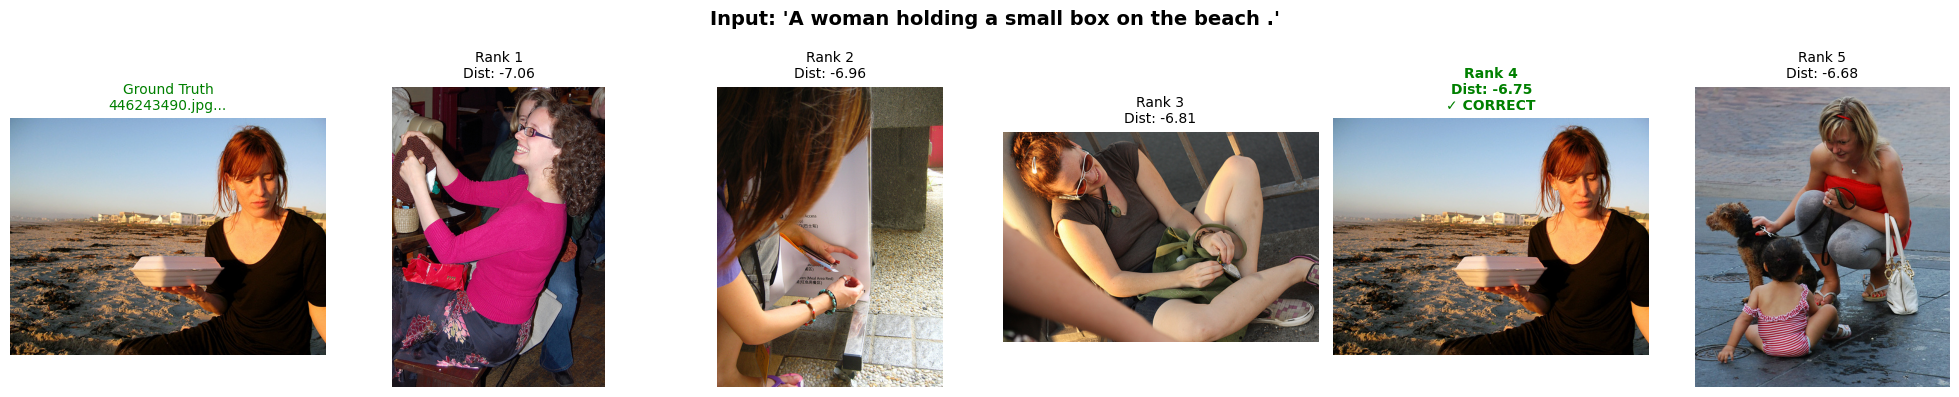

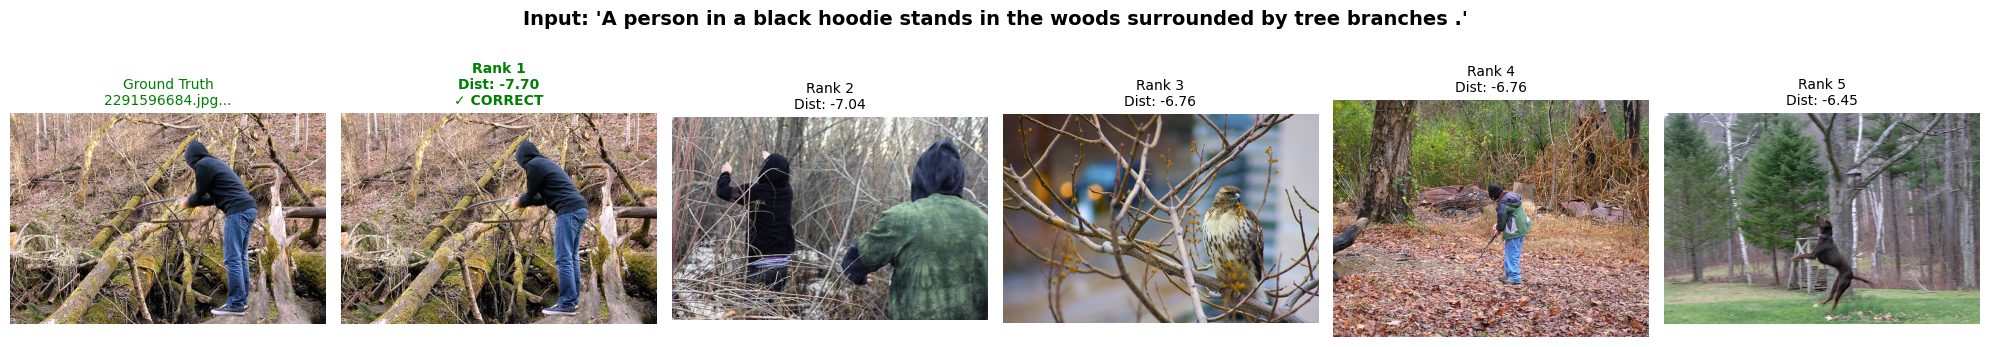

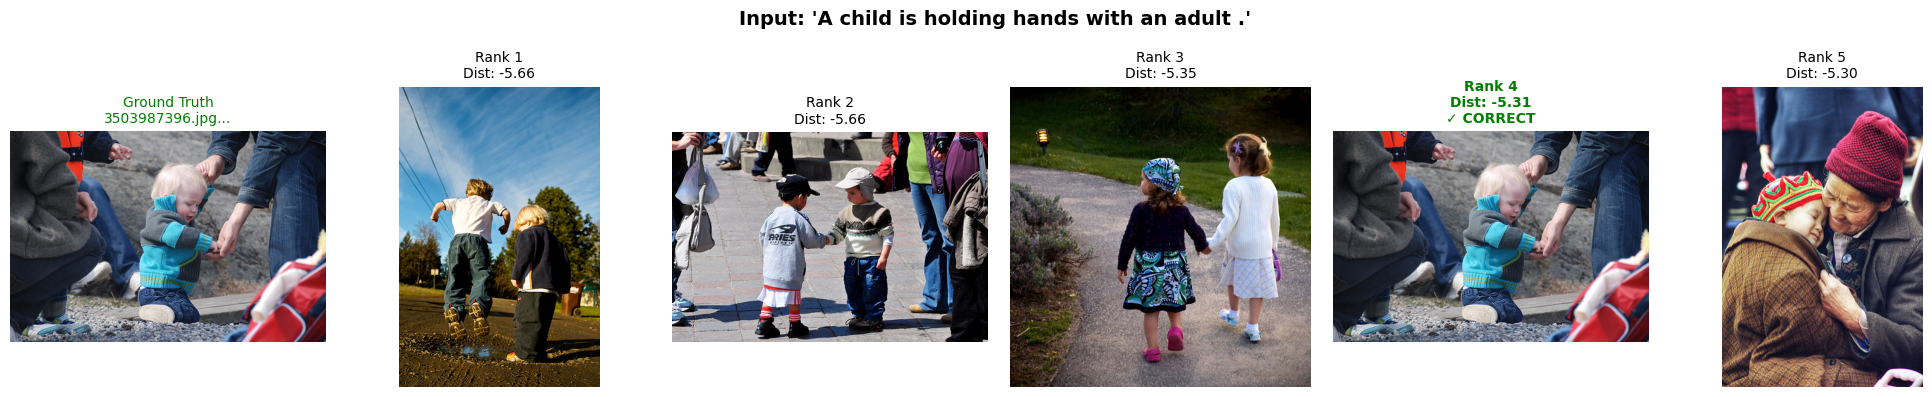


=== agg='mean' ===
mrr            : 0.4282
ndcg           : 0.5651
recall_at_1    : 0.1845
recall_at_3    : 0.5498
recall_at_5    : 0.9147
recall_at_10   : 0.9697
recall_at_50   : 0.9988
l2_dist        : 1.2109

=== agg='winner' ===
mrr            : 0.4326
ndcg           : 0.5691
recall_at_1    : 0.1864
recall_at_3    : 0.5558
recall_at_5    : 0.9292
recall_at_10   : 0.9782
recall_at_50   : 0.9991
l2_dist        : 1.2524


In [36]:
# Carica best e imposta eval
state = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# ============================================================
# 9) Aggregazione slot -> 1 embedding (submission compatibile)
# ============================================================
@torch.no_grad()
def aggregate_slots(S_T: torch.Tensor, V_ref: torch.Tensor | None = None, mode: str = "mean"):
    """
    S_T:   (B, K, D)  slots già L2-normalizzati
    V_ref: (B, D)     opzionale, solo per mode="winner" (deve essere batch-aligned!)
    Ritorna: (B, D) L2-normalizzato
    """
    # Caso (B,K,D) -> assicura batch-dim
    assert S_T.dim() == 3, f"aggregate_slots: atteso (B,K,D), trovato {tuple(S_T.shape)}"
    if mode == "mean" or V_ref is None:
        out = S_T.mean(dim=1)                  # (B, D)
        return F.normalize(out, dim=-1)

    # winner-slot richiede un riferimento allineato per ogni sample
    assert V_ref is not None, "mode='winner' richiede V_ref"
    assert V_ref.dim() == 2 and V_ref.size(0) == S_T.size(0), \
        f"V_ref shape mismatch: atteso (B,D) con B={S_T.size(0)}, trovato {tuple(V_ref.shape)}"

    Vn = F.normalize(V_ref, dim=-1)            # (B, D)
    # Similarità per-sample: per ogni b, sim di ciascuno slot verso V_ref[b]
    sims = torch.einsum('bkd,bd->bk', S_T, Vn) # (B, K)
    idx  = sims.argmax(dim=1)                  # (B,)
    out  = S_T[torch.arange(S_T.size(0), device=S_T.device), idx, :]  # (B, D)
    return F.normalize(out, dim=-1)


# Visualizza qualche retrieval
import numpy as np
val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_VAL_SPLIT])
val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:, img_VAL_SPLIT])[1]

for i in range(3):
    idx = np.random.randint(0, min(100, len(val_text_embd)))
    caption_embd = val_text_embd[idx:idx+1].to(DEVICE)
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]
    with torch.no_grad():
        S_T, _, _ = model(caption_embd)
        pred_embd = aggregate_slots(S_T, mode="mean").cpu().squeeze(0)
        visualize_retrieval(pred_embd, gt_index, val_img_file, caption_text, val_img_embd, k=5)

# --- Valutazione coerente (unico blocco) ---
with torch.no_grad():
    preds_val_mean, preds_val_win = [], []
    for Xb, Yb in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
        Xb = Xb.to(DEVICE); Yb = Yb.to(DEVICE)
        S_Tb, _, _ = model(Xb)                              # (B,K,D)
        preds_val_mean.append(aggregate_slots(S_Tb, mode="mean").cpu())
        preds_val_win.append(aggregate_slots(S_Tb, V_ref=Yb, mode="winner").cpu())

Z_mean = F.normalize(torch.cat(preds_val_mean, dim=0), dim=-1).cpu()
Z_win  = F.normalize(torch.cat(preds_val_win,  dim=0), dim=-1).cpu()

# Equalizza e RIORDINA: un'immagine per caption, esattamente la sua GT
nq        = Z_mean.size(0)
gt_equal  = np.asarray(val_label[:nq], dtype=np.int64)         # (Nq,)
IMG_ALL_n = F.normalize(val_img_embd, dim=-1).cpu()            # (Nimg,D)
IMG_EQ    = IMG_ALL_n[torch.from_numpy(gt_equal)]              # (Nq,D)
gt_re     = np.arange(nq, dtype=np.int64)                      # 0..Nq-1

def best_divisor(n, cap=100):
    for d in [cap, 64, 50, 40, 32, 25, 20, 16, 10, 8, 5, 4, 2, 1]:
        if d <= n and n % d == 0:
            return d
    for d in range(min(cap, n), 0, -1):
        if n % d == 0: return d
    return 1

safe_batch = best_divisor(nq, 100)
safe_k     = min(50, safe_batch)   # deve valere: max_indices ≤ batch

res_mean = evaluate_retrieval(
    translated_embd=Z_mean, 
    image_embd=IMG_EQ, 
    gt_indices=gt_re,
    max_indices=safe_k,
    batch_size=safe_batch
)
res_win = evaluate_retrieval(
    translated_embd=Z_win, 
    image_embd=IMG_EQ, 
    gt_indices=gt_re,
    max_indices=safe_k,
    batch_size=safe_batch
)

print("\n=== agg='mean' ===")
for k,v in res_mean.items(): print(f"{k:15s}: {v:.4f}")
print("\n=== agg='winner' ===")
for k,v in res_win.items():  print(f"{k:15s}: {v:.4f}")





    === agg='mean' ===
    mrr            : 0.4220
    ndcg           : 0.5598
    recall_at_1    : 0.1794
    recall_at_3    : 0.5408
    recall_at_5    : 0.9049
    recall_at_10   : 0.9625
    recall_at_50   : 0.9978
    l2_dist        : 1.2193

    === agg='winner' ===
    mrr            : 0.4255
    ndcg           : 0.5632
    recall_at_1    : 0.1809
    recall_at_3    : 0.5440
    recall_at_5    : 0.9212
    recall_at_10   : 0.9706
    recall_at_50   : 0.9987
    l2_dist        : 1.2519

In [35]:
# ============================================================
# 10) Submission (robusta)
# ============================================================
test_data   = load_data("data/test/test.clean.npz")
test_ids    = test_data['captions/ids']
test_embds  = torch.from_numpy(test_data['captions/embeddings']).float()  # (N,D_t)

pred_chunks = []
with torch.inference_mode():
    model.eval()
    for Xb in DataLoader(test_embds, batch_size=BATCH_SIZE, shuffle=False):
        Xb = Xb.to(DEVICE, non_blocking=False)
        S_Tb, _, _ = model(Xb)                    # (B,K,D)
        Eb = aggregate_slots(S_Tb, mode="mean")# (B,D) già L2-normalizzato
        pred_chunks.append(Eb.cpu().to(torch.float32))

pred_embds_test = torch.cat(pred_chunks, dim=0)  # (N,D) CPU float32

# sanity checks
assert pred_embds_test.ndim == 2, f"Got shape {tuple(pred_embds_test.shape)}"
assert len(test_ids) == pred_embds_test.size(0), \
    f"ids({len(test_ids)}) != preds({pred_embds_test.size(0)})"

# opzionale: salva per analisi locale
np.save("pred_test_embeddings.npy", pred_embds_test.numpy())

# genera CSV (funzione del prof accetta anche torch.Tensor)
submission = generate_submission(test_ids, pred_embds_test, 'submission.csv')
print(f"Model saved to: {MODEL_PATH}")
print("Submission saved to: submission.csv")

Generating submission file...
✓ Saved submission to submission.csv
Model saved to: models/maxmatch_adapter_k4_sinkhorn.pth
Submission saved to: submission.csv
